In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
file_name = 'Case_Study_Data_AIS.xlsx'

huc0 = pd.read_excel(file_name, sheet_name=0, index_col='Date')
g202 = pd.read_excel(file_name, sheet_name=1, index_col='Date')

### 1. Using pandas join the G202 - BAML 3-5Year UST Total Return Index to the HUC0 – BAML HY INDEX data

In [4]:
df = huc0.join(g202, lsuffix="_huc0", rsuffix="_g202").rename(columns = {'OAS': 'OAS_huc0'})
df.head()

,Index_huc0,Description_huc0,OAS_huc0,Total Return Index Value -LOC_huc0,Index_g202,Description_g202,Total Return Index Value -LOC_g202
Date,,,,,,,
2010-01-04,HUC0,ICE BofA US High Yield Constrained Index,619,227.780,G2O2,ICE BofA 3-5 Year US Treasury Index,1648.780
2010-01-05,HUC0,ICE BofA US High Yield Constrained Index,615,228.883,G2O2,ICE BofA 3-5 Year US Treasury Index,1654.636
2010-01-06,HUC0,ICE BofA US High Yield Constrained Index,602,229.927,G2O2,ICE BofA 3-5 Year US Treasury Index,1653.533
2010-01-07,HUC0,ICE BofA US High Yield Constrained Index,588,231.046,G2O2,ICE BofA 3-5 Year US Treasury Index,1652.081
2010-01-08,HUC0,ICE BofA US High Yield Constrained Index,588,231.497,G2O2,ICE BofA 3-5 Year US Treasury Index,1654.532


### 2. Using pandas and the data provided compute deciles on HUC0 OAS

In [5]:
df['OAS_huc0_decile'] = pd.qcut(df['OAS_huc0'], 10, labels=False)
df[['OAS_huc0', 'OAS_huc0_decile']].head()

,OAS_huc0,OAS_huc0_decile
Date,,
2010-01-04,619,8
2010-01-05,615,8
2010-01-06,602,7
2010-01-07,588,7
2010-01-08,588,7


### 3. Compute 1YR forward HUC0 returns using the total return index provided

In [44]:
##assume 263 BD days in a year 
## add where 263 ..TODD
df['forward_1yr'] = df['Total Return Index Value -LOC_huc0']/df['Total Return Index Value -LOC_huc0'].shift(263) - 1

### 4.  Show descriptive statistics on 1YR forward returns by OAS decile

In [50]:
stats = df.groupby(['OAS_huc0_decile']).agg({'forward_1yr': [np.mean, np.median, np.min, np.max, np.std, pd.Series.count]})
stats

forward_1yr                                               
                       mean    median      amin      amax       std  count
OAS_huc0_decile                                                           
0                  0.081491  0.067544  0.015098  0.343163  0.063471  307.0
1                  0.088889  0.077867  0.008811  0.310492  0.048808  291.0
2                  0.100169  0.083477  0.006783  0.264169  0.052451  292.0
3                  0.080471  0.069882 -0.001298  0.236470  0.044891  304.0
4                  0.078202  0.069329 -0.004118  0.189358  0.053662  297.0
5                  0.094038  0.106060 -0.011329  0.190914  0.055491  295.0
6                  0.082858  0.081493 -0.027579  0.221696  0.066895  254.0
7                  0.053394  0.052533 -0.036978  0.200936  0.063275  216.0
8                  0.013478  0.003838 -0.040525  0.102700  0.038292  189.0
9                 -0.011783 -0.028118 -0.150278  0.087628  0.057750  258.0

### 5. Produce a bar chart of the median forward 1YR HUC0 returns by OAS decile

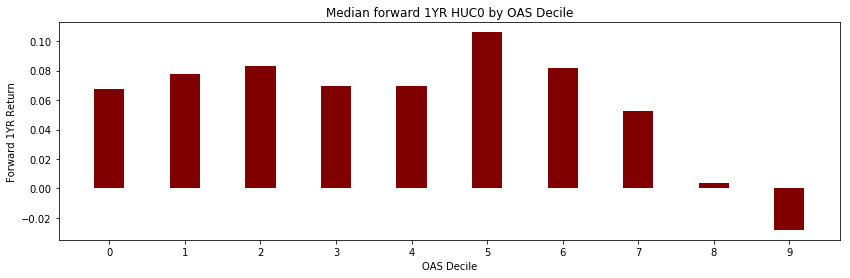

In [53]:
fig, ax = plt.subplots()

ax.set_xticks(stats.index)
ax.bar(stats.index, height=stats.forward_1yr['median'], color='maroon', width=0.4)
ax.set_title("Median forward 1YR HUC0 by OAS Decile")
ax.set_xlabel("OAS Decile")
ax.set_ylabel("Forward 1YR Return")
fig.set_figwidth(14)

### 6. Produce a bar chart of the median OAS by OAS decile

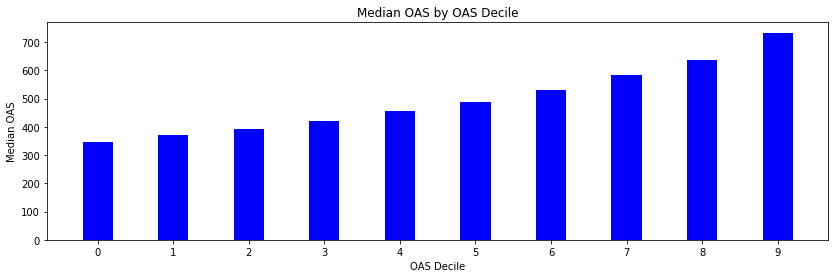

In [54]:
oas_data = df.groupby(['OAS_huc0_decile']).agg({'OAS_huc0': np.median}).rename(columns = {'OAS_huc0':'median'})

fig, ax = plt.subplots()

ax.set_xticks(stats.index)
ax.bar(oas_data.index, height=oas_data['median'], color='blue', width=0.4)
ax.set_title("Median OAS by OAS Decile")
ax.set_xlabel("OAS Decile")
ax.set_ylabel("Median OAS")
fig.set_figwidth(14)

### 7. Using the daily returns from HUC0 compute a rolling 6-month Sharpe ratio (assume no risk free rate)

In [98]:
# used log return 
daily_rets = np.log(df['Total Return Index Value -LOC_huc0']/ df['Total Return Index Value -LOC_huc0'].shift(1))

# daily_rets = df['Total Return Index Value -LOC_huc0']/ df['Total Return Index Value -LOC_huc0'].shift(1) - 1
df['daily_rets_huc0'] = daily_rets

# used exact number of days in 6 month
rolling_sharpe_6m = lambda x: np.sqrt(len(x)) * x.mean()/ x.std() 

sd = df.index[0]
sd = sd + pd.offsets.DateOffset(months=6)

ratios = [rolling_sharpe_6m(df.loc[d - pd.offsets.DateOffset(months=6): d, 'daily_rets_huc0']) for d in df[sd:].index]

sharpe_df = pd.DataFrame(ratios).rename(columns={0:'sharpe_ratio'})
sharpe_df.set_index(df[sd:].index, inplace=True)

In [100]:
sharpe_df.head()

,sharpe_ratio
Date,
2010-07-05,1.286796
2010-07-06,1.210108
2010-07-07,1.099994
2010-07-08,1.064464
2010-07-09,1.085993


### 8. What is the median, 25th and 75th percentile of the rolling distribution?

In [101]:
print(f"median is: {round(sharpe_df.describe().loc['50%'].values[0], 4)}")
print(f"25th percentile is: {round(sharpe_df.describe().loc['25%'].values[0], 4)}")
print(f"75th percentile is: {round(sharpe_df.describe().loc['75%'].values[0], 4)}")

median is: 2.0268
25th percentile is: 0.2895
75th percentile is: 3.2783


### 9. Compute .05/.95 confidence intervals on the mean Sharpe ratio from the rolling distribution

In [105]:
mu = sharpe_df.mean().values[0]
sigma = sharpe_df.std().values[0]
z = 1.96 
print(f"CI is: ({round(mu - z * sigma, 4)}, {round(mu + z * sigma, 4)}) ")

CI is: (-2.0787, 5.916) 


### 10. In pandas compute and plot EWM daily volatility on the HUC0 total return series. Use span=100.

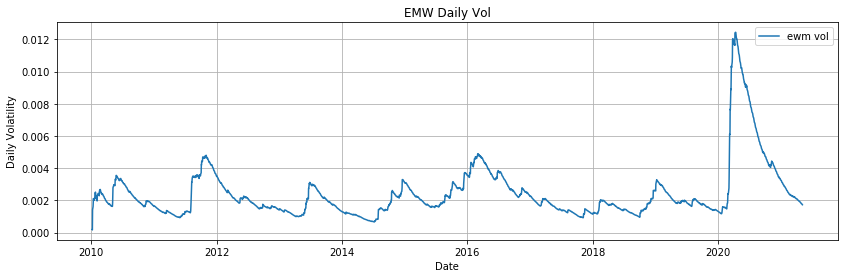

In [130]:
SPAN= 100 

df['vol'] = df['daily_rets_huc0'].ewm(span=SPAN).std()

fig, ax = plt.subplots()
ax.plot(df['vol'], label='ewm vol')
ax.set_title("EMW Daily Vol")
ax.set_xlabel("Date")
ax.set_ylabel("Daily Volatility")
ax.grid(True)
ax.legend()
fig.set_figwidth(14)

### 11. Using the volatility series in #10 compute the current daily VaR of the HUC0 at alpha=.05.

In [126]:
import scipy.stats as stats
z_score = stats.norm.ppf(1 - 0.05)
df['daily_var'] = z_score * df['vol']

Assume current daily VaR asked is based on the last day of data, as of 5/7/2021

In [127]:
cur_daily_var = df['daily_var'][-1]
print(f'current daily VaR : {round(cur_daily_var, 4)}')

current daily VaR : 0.0028


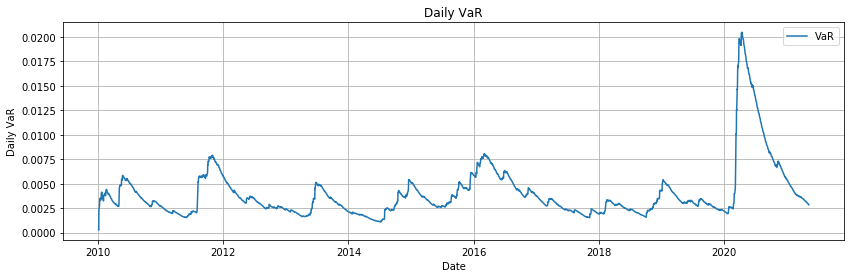

In [128]:
fig, ax = plt.subplots()
ax.plot(df['daily_var'], label='VaR')
ax.set_title("Daily VaR")
ax.set_xlabel("Date")
ax.set_ylabel("Daily VaR")
ax.legend()
ax.grid(True)
fig.set_figwidth(14)